# Think Bayes

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite

import thinkbayes2
import thinkplot

Suppose there are 10 people in my *Dungeons and Dragons* club; on any game day, each of them has a 70% chance of showing up.

Each player has one character and each character has 6 attributes, each of which is generated by rolling and adding up 3 6-sided dice.

At the beginning of the game, I ask whose character has the lowest attribute. The wizard says, "My constitution is 5; does anyone have a lower attribute?", and no one does.

The warrior says "My strength is 16; does anyone have a higher attribute?", and no one does.

How many characters are in the party?

### The prior

There are three ways to compute the prior distribution:

* Simulation

* Convolution

* Analytic distribution

First, simulation.  Here's a function that flips a coin with probability `p`:

In [2]:
from random import random

def flip(p):
    return random() < p

We can use it to flip a coin for each member of the club.

In [3]:
flips = [flip(0.7) for i in range(10)]

[False, True, True, False, True, False, True, True, False, True]

And count the number that show up on game day.

In [4]:
sum(flips)

6

Let's encapsulate that in a function that simulates a game day.

In [5]:
def game_day(n, p):
    flips = [flip(p) for i in range(n)]
    return sum(flips)

In [6]:
game_day(10, 0.7)

5

If we run that function many times, we get a sample from the distribution of the number of players.

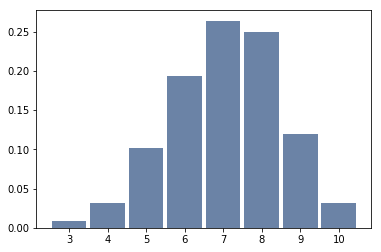

In [7]:
sample = [game_day(10, 0.7) for i in range(1000)]
pmf_sample = Pmf(sample)
thinkplot.Hist(pmf_sample)

The second method is convolution.  Instead of flipping a coin, we can create a `Pmf` object that represents the distribution of outcomes from a single flip.

In [8]:
def coin(p):
    return Pmf({1:p, 0:1-p})

Here's what it looks like.

In [9]:
player = coin(0.7)
player.Print()

0 0.30000000000000004
1 0.7


If we have two players, there are three possible outcomes:

In [10]:
(player + player).Print()

0 0.09000000000000002
1 0.42000000000000004
2 0.48999999999999994


If we have 10 players, we can get the prior distribution like this:

In [11]:
prior = sum([player]*10)
prior.Print()

0 5.9049000000000085e-06
1 0.00013778100000000018
2 0.0014467005000000017
3 0.009001692000000009
4 0.036756909000000025
5 0.10291934520000004
6 0.20012094900000005
7 0.26682793200000005
8 0.2334744405
9 0.12106082099999994
10 0.028247524899999984


Now we can compare the results of simulation and convolution:

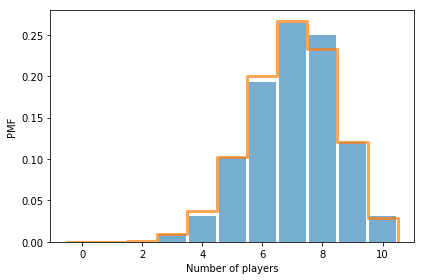

In [12]:
thinkplot.Hist(pmf_sample, color='C0')
thinkplot.Pmf(prior, color='C1')

thinkplot.decorate(xlabel='Number of players',
                   ylabel='PMF')

Finally, we can use an analytic distribution.  The distribution we just computed is the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution), which has the following PMF:

$ PMF(k; n, p) = P(k ~|~ n, p) = {n \choose k}\,p^{k}(1-p)^{n-k}$

We could evalate the right hand side in Python, or use `MakeBinomialPmf`:



In [13]:
help(thinkbayes2.MakeBinomialPmf)

Help on function MakeBinomialPmf in module thinkbayes2.thinkbayes2:

MakeBinomialPmf(n, p)
    Evaluates the binomial PMF.
    
    n: number of trials
    p: probability of success on each trial
    
    Returns: Pmf of number of successes



And we can confirm that the analytic result matches what we computed by convolution.

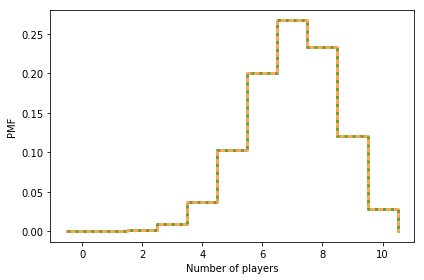

In [14]:
binomial = thinkbayes2.MakeBinomialPmf(10, 0.7)
thinkplot.Pmf(prior, color='C1')
thinkplot.Pmf(binomial, color='C2', linestyle='dotted')

thinkplot.decorate(xlabel='Number of players',
                   ylabel='PMF')

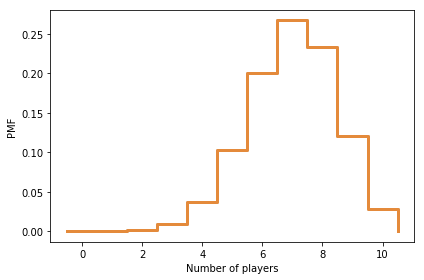

In [15]:
thinkplot.Pmf(prior, color='gray')
prior[0] = 0
prior[1] = 0
prior.Normalize()
thinkplot.Pmf(prior, color='C1')

thinkplot.decorate(xlabel='Number of players',
                   ylabel='PMF')

### Likelihood

In [16]:
d6 = Pmf([1,2,3,4,5,6])
d6.Print()

1 0.16666666666666666
2 0.16666666666666666
3 0.16666666666666666
4 0.16666666666666666
5 0.16666666666666666
6 0.16666666666666666


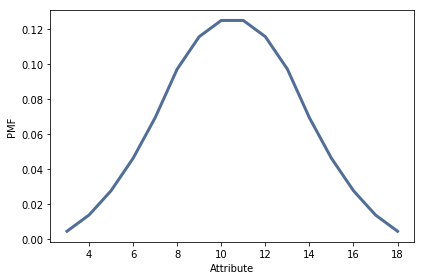

In [17]:
thrice = sum([d6] * 3)
thinkplot.Pdf(thrice)
thinkplot.decorate(xlabel='Attribute',
                   ylabel='PMF')

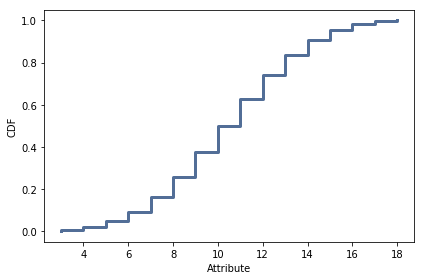

In [18]:
cdf_thrice = thrice.MakeCdf()
thinkplot.Cdf(cdf_thrice)
thinkplot.decorate(xlabel='Attribute',
                   ylabel='CDF')

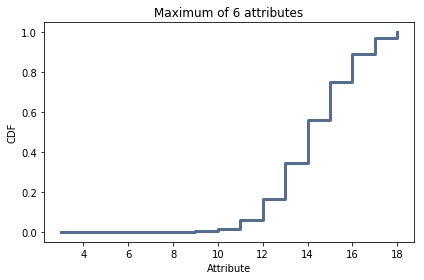

In [19]:
cdf_max_6 = cdf_thrice.Max(6)
thinkplot.Cdf(cdf_max_6)
thinkplot.decorate(xlabel='Attribute',
                   ylabel='CDF',
                   title='Maximum of 6 attributes')

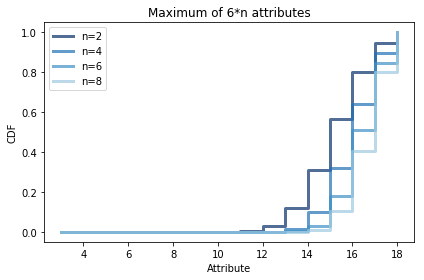

In [20]:
for n in range(2, 10, 2):
    cdf_max = cdf_thrice.Max(n*6)
    thinkplot.Cdf(cdf_max, label='n=%s'%n)

thinkplot.decorate(xlabel='Attribute',
                   ylabel='CDF',
                   title='Maximum of 6*n attributes')

In [21]:
def compute_cdf_min(cdf, k):
    cdf_min = cdf.Copy()
    cdf_min.ps = 1 - (1 - cdf_min.ps)**k
    return cdf_min

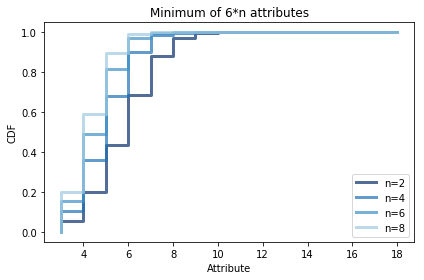

In [23]:
for n in range(2, 10, 2):
    cdf = compute_cdf_min(cdf_thrice, n*6)
    thinkplot.Cdf(cdf, label='n=%s'%n)

thinkplot.decorate(xlabel='Attribute',
                   ylabel='CDF',
                   title='Minimum of 6*n attributes')

{'xscale': 'linear', 'yscale': 'linear'}

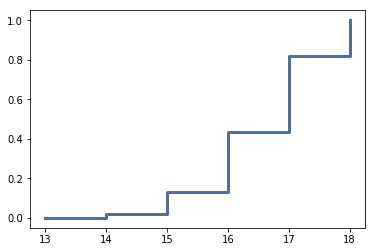

In [32]:
sample_max = [max(cdf_thrice.Sample(42)) for i in range(1000)]
thinkplot.Cdf(thinkbayes2.Cdf(sample_max))